In [1]:
import os
import myutils

path2data = "./data"
sub_folder_jpg = "hmdb51_jpg"
path2ajpgs = os.path.join(path2data, sub_folder_jpg)

In [2]:
all_vids, all_labels, catgs = myutils.get_vids(path2ajpgs) 
len(all_vids), len(all_labels), len(catgs)

(6766, 6766, 51)

In [3]:
all_vids[:1], all_labels[:3], catgs[:5]

(['./data/hmdb51_jpg/smile/YouTube_smiles!_smile_h_nm_np1_fr_med_24'],
 ['smile', 'smile', 'smile'],
 ['smile', 'golf', 'wave', 'drink', 'clap'])

In [4]:
labels_dict = {}
ind = 0
for uc in catgs:
    labels_dict[uc] = ind
    ind+=1
labels_dict

{'smile': 0,
 'golf': 1,
 'wave': 2,
 'drink': 3,
 'clap': 4,
 'smoke': 5,
 'kick_ball': 6,
 'shoot_bow': 7,
 'run': 8,
 'ride_horse': 9,
 'turn': 10,
 'dribble': 11,
 'somersault': 12,
 'fall_floor': 13,
 'pour': 14,
 'handstand': 15,
 'punch': 16,
 'kick': 17,
 'fencing': 18,
 'situp': 19,
 'shoot_ball': 20,
 'chew': 21,
 'talk': 22,
 'sword': 23,
 'hug': 24,
 'eat': 25,
 'flic_flac': 26,
 'ride_bike': 27,
 'push': 28,
 'climb': 29,
 'catch': 30,
 'hit': 31,
 'throw': 32,
 'swing_baseball': 33,
 'shake_hands': 34,
 'pick': 35,
 'walk': 36,
 'draw_sword': 37,
 'laugh': 38,
 'kiss': 39,
 'stand': 40,
 'climb_stairs': 41,
 'shoot_gun': 42,
 'sit': 43,
 'pushup': 44,
 'pullup': 45,
 'cartwheel': 46,
 'dive': 47,
 'jump': 48,
 'sword_exercise': 49,
 'brush_hair': 50}

In [5]:
num_classes =5
unique_ids = [id_ for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
unique_labels = [label for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
len(unique_ids),len(unique_labels)

(605, 605)

In [6]:
len(set(unique_labels))

5

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
train_indx, test_indx = next(sss.split(unique_ids, unique_labels))

train_ids = [unique_ids[ind] for ind in train_indx]
train_labels = [unique_labels[ind] for ind in train_indx]
print(len(train_ids), len(train_labels)) 

test_ids = [unique_ids[ind] for ind in test_indx]
test_labels = [unique_labels[ind] for ind in test_indx]
print(len(test_ids), len(test_labels))

544 544
61 61


In [8]:
train_ids[:5], train_labels[:5]

(['./data/hmdb51_jpg/golf/Meena_Lee_golf_f_cm_np1_ba_med_2',
  './data/hmdb51_jpg/drink/GoneBabyGone_drink_u_cm_np1_le_med_2',
  './data/hmdb51_jpg/golf/Lorena_Ochoa_et_Paula_Creamer_golf_f_cm_np1_le_med_0',
  './data/hmdb51_jpg/wave/Bush_Wave_vs__Obama_Wave_and_Which_Commander-in-chief_Salutes_the_Best__You_Decide_wave_u_cm_np1_fr_med_2',
  './data/hmdb51_jpg/wave/BIG_FISH_wave_u_nm_np1_le_goo_28'],
 ['golf', 'drink', 'golf', 'wave', 'wave'])

In [9]:
test_ids[:5], test_labels[:5]

(['./data/hmdb51_jpg/smile/YouTube_smiles!_smile_h_nm_np1_fr_goo_9',
  './data/hmdb51_jpg/drink/RETURN_OF_THE_KING_drink_u_cm_np2_fr_goo_2',
  './data/hmdb51_jpg/clap/boomsnapclap!_clap_u_nm_np1_fr_med_1',
  './data/hmdb51_jpg/wave/Bush_Wave_vs__Obama_Wave_and_Which_Commander-in-chief_Salutes_the_Best__You_Decide_wave_u_cm_np1_fr_med_10',
  './data/hmdb51_jpg/smile/YouTube_smiles!_smile_h_nm_np1_fr_bad_27'],
 ['smile', 'drink', 'clap', 'wave', 'smile'])

In [10]:
from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import torch
import numpy as np
import random
np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform):      
        self.transform = transform
        self.ids = ids
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        path2imgs=glob.glob(self.ids[idx]+"/*.jpg")
        path2imgs = path2imgs[:timesteps]
        label = labels_dict[self.labels[idx]]
        frames = []
        for p2i in path2imgs:
            frame = Image.open(p2i)
            frames.append(frame)
        
        seed = np.random.randint(1e9)        
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, label

In [11]:
model_type = "rnn"    

timesteps =16
if model_type == "rnn":
    h, w =224, 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
else:
    h, w = 112, 112
    mean = [0.43216, 0.394666, 0.37645]
    std = [0.22803, 0.22145, 0.216989]

In [12]:
import torchvision.transforms as transforms

train_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.RandomHorizontalFlip(p=0.5),  
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),    
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])


In [13]:
train_ds = VideoDataset(ids= train_ids, labels= train_labels, transform= train_transformer)
print(len(train_ds))

544


In [14]:
imgs, label = train_ds[10]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([16, 3, 224, 224]), 1, tensor(-2.1179), tensor(2.6400))

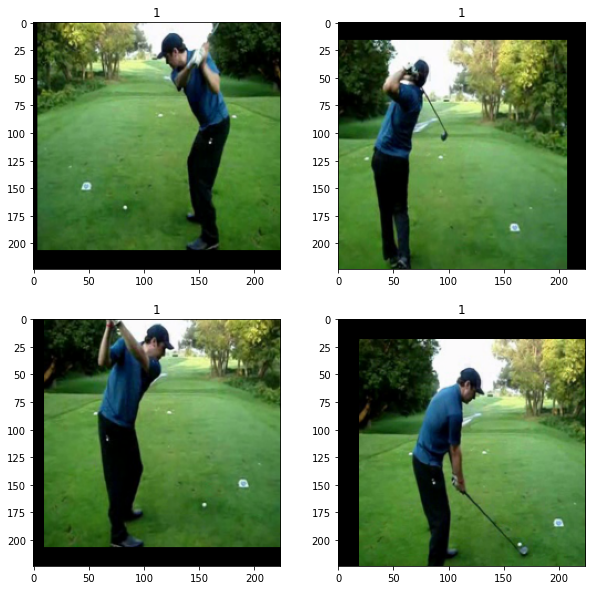

In [15]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::4]):
    plt.subplot(2,2,ii+1)
    plt.imshow(myutils.denormalize(img, mean, std))
    plt.title(label)

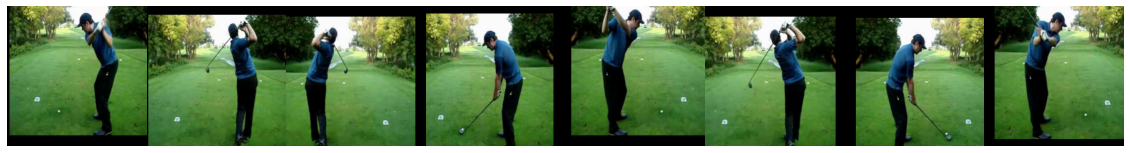

In [16]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0, hspace=0)
for ii,img in enumerate(imgs[::2]):
    plt.subplot(1,8,ii+1)
    plt.imshow(myutils.denormalize(img, mean, std))
    plt.axis("off")

In [17]:
test_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ]) 
test_ds = VideoDataset(ids= test_ids, labels= test_labels, transform= test_transformer)
print(len(test_ds))


61


In [18]:
imgs, label = test_ds[5]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([16, 3, 224, 224]), 3, tensor(-2.1179), tensor(2.1804))

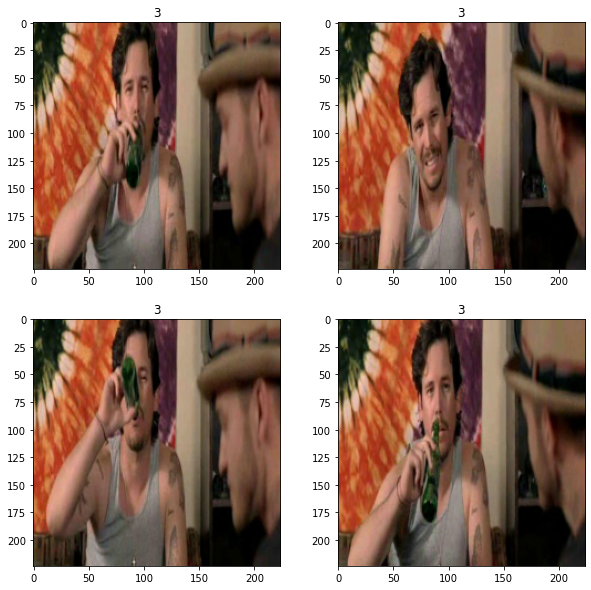

In [19]:
plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::4]):
    plt.subplot(2,2,ii+1)
    plt.imshow(myutils.denormalize(img, mean, std))
    plt.title(label)

In [20]:
def collate_fn_r3d_18(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

def collate_fn_rnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor
    

batch_size = 32
if model_type == "rnn":
    train_dl = DataLoader(train_ds, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn_rnn)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size,
                         shuffle=False, collate_fn= collate_fn_rnn)  
else:
    train_dl = DataLoader(train_ds, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn_r3d_18)
    test_dl = DataLoader(test_ds, batch_size= batch_size,
                         shuffle=False, collate_fn= collate_fn_r3d_18)

In [21]:
for xb,yb in train_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([32, 16, 3, 224, 224]) torch.Size([32])


In [22]:
for xb,yb in test_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([61, 16, 3, 224, 224]) torch.Size([61])


In [23]:
from torch import nn
import torch.nn.functional as F
class Resnt18Rnn(nn.Module):
    def __init__(self, params_model):
        super(Resnt18Rnn, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        
        baseModel = models.resnet18(pretrained=pretrained, progress=False)
        num_features = baseModel.fc.in_features
        baseModel.fc = Identity()
        self.baseModel = baseModel
        self.dropout= nn.Dropout(dr_rate)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers,batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        
        self.attn = nn.Linear((rnn_hidden_size * 2), rnn_hidden_size)
        self.v = nn.Linear(rnn_hidden_size, 1, bias = False)
        
    def forward(self, x):
        b_z, ts, c, h, w = x.shape
        ii = 0
        y = self.baseModel((x[:,ii]))
#         print(y.requires_grad)
        output_list = []
#         print(y.shape)
        output, (hn, cn) = self.rnn(y.unsqueeze(1))
#         print(hn.shape)
        output_list.append(output)
        for ii in range(1, ts):
            y = self.baseModel((x[:,ii]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
            output_list.append(out)
#         print(out.shape)
        
        output_list = torch.stack(output_list).squeeze(2)
        output_list = output_list.permute(1,0,2)
        #output_list: [batch, seq_len, hidden_dim]
        
        
        out = self.dropout(out[:,-1])
        out.squeeze(1)
        #out [batch, hidden_dim]
        
        src_len = output_list.shape[1]
        
        hidden = out.unsqueeze(1).repeat(1, src_len, 1)
        
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        
        energy = torch.tanh(self.attn(torch.cat((hidden, output_list), dim = 2))) 
        #energy = [batch size, src len, dec hid dim]
        
        
        attention = self.v(energy).squeeze(2)
        #attention = [batch size, src len]
        
        a = F.softmax(attention, dim = 1)
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
#         encoder_outputs = output_list.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, output_list)
        #weighted = [batch size, 1, enc hid dim * 2]
        
        out = weighted[:,0,:]
        out = self.fc1(out) 
        return out 
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

In [24]:
from torchvision import models
from torch import nn

if model_type == "rnn":
    params_model={
        "num_classes": num_classes,
        "dr_rate": 0.3,
        "pretrained" : True,
        "rnn_num_layers": 1,
        "rnn_hidden_size": 100,}
    model = Resnt18Rnn(params_model)        
else:
    model = models.video.r3d_18(pretrained=True, progress=False)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

In [25]:
with torch.no_grad():
    if model_type=="rnn":
        x = torch.zeros(64, 16, 3, h, w)
    else:
        x = torch.zeros(64, 3, 16, h, w)
    y= model(x)
    print(y.shape)

torch.Size([64, 5])


In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [31]:
# model

In [32]:
path2weights = "./models/weights.pt"
torch.save(model.state_dict(), path2weights)

In [33]:
import time
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=3e-5)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5,verbose=1)
os.makedirs("./models", exist_ok=True)

params_train={
    "num_epochs": 20,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": test_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": "./models/weights_"+model_type+".pt",
    }
start = time.time()
model,loss_hist,metric_hist = myutils.train_val(model,params_train)
end = time.time()
print((end-start)//60,'secs')

Epoch 0/19, current lr=3e-05


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.466872, dev loss: 1.335133, accuracy: 68.85
----------
Epoch 1/19, current lr=3e-05


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 1.164942, dev loss: 1.111256, accuracy: 75.41
----------
Epoch 2/19, current lr=3e-05


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.942053, dev loss: 0.925351, accuracy: 80.33
----------
Epoch 3/19, current lr=3e-05


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.773983, dev loss: 0.833735, accuracy: 77.05
----------
Epoch 4/19, current lr=3e-05


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.620479, dev loss: 0.723063, accuracy: 78.69
----------
Epoch 5/19, current lr=3e-05


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.511867, dev loss: 0.666004, accuracy: 78.69
----------
Epoch 6/19, current lr=3e-05


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.416669, dev loss: 0.596738, accuracy: 81.97
----------
Epoch 7/19, current lr=3e-05


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.339213, dev loss: 0.576344, accuracy: 83.61
----------
Epoch 8/19, current lr=3e-05


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.282476, dev loss: 0.549804, accuracy: 78.69
----------
Epoch 9/19, current lr=3e-05


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.217154, dev loss: 0.481456, accuracy: 83.61
----------
Epoch 10/19, current lr=3e-05


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.181471, dev loss: 0.447375, accuracy: 86.89
----------
Epoch 11/19, current lr=3e-05


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.154290, dev loss: 0.442386, accuracy: 86.89
----------
Epoch 12/19, current lr=3e-05


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.126310, dev loss: 0.440858, accuracy: 88.52
----------
Epoch 13/19, current lr=3e-05


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.117178, dev loss: 0.428176, accuracy: 86.89
----------
Epoch 14/19, current lr=3e-05


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.103134, dev loss: 0.501793, accuracy: 86.89
----------
Epoch 15/19, current lr=3e-05


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.090779, dev loss: 0.483237, accuracy: 85.25
----------
Epoch 16/19, current lr=3e-05


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.079164, dev loss: 0.457453, accuracy: 85.25
----------
Epoch 17/19, current lr=3e-05


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.071055, dev loss: 0.488435, accuracy: 86.89
----------
Epoch 18/19, current lr=3e-05


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.065988, dev loss: 0.491500, accuracy: 85.25
----------
Epoch 19/19, current lr=3e-05


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch    20: reducing learning rate of group 0 to 1.5000e-05.
Loading best model weights!
train loss: 0.060699, dev loss: 0.457065, accuracy: 86.89
----------
14.0 secs


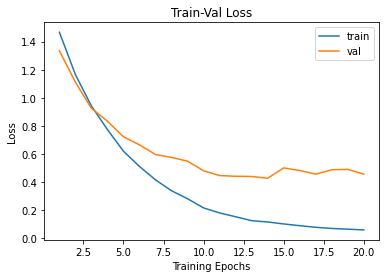

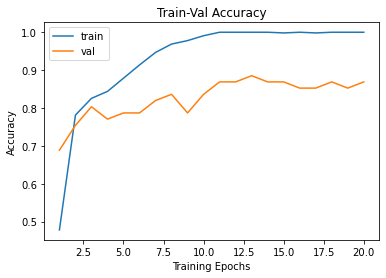

In [34]:
myutils.plot_loss(loss_hist, metric_hist)